# RAG Document Q&A System

## Features
- Document ingestion (`PDF`/`TXT`/`DOCX`)
- Vector database management (`Chroma`/`FAISS`)
- Gemini-powered conversational Q&A
- Context-aware responses with source citations

In [1]:
# packages
!pip install -q langchain langchain_google_genai langchain_community unstructured pdf2image pytesseract pdfminer.six python-docx chromadb sentence-transformers google-generativeai ipywidgets faiss-cpu
!pip install -U langchain-unstructured
# HuggingFaceEmbeddings
!pip install -q langchain-huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import necessary libraries
import os
import tempfile
import shutil
import re
import glob
from typing import List, Dict, Any, Tuple, Optional, Union
from pathlib import Path
import numpy as np
import uuid
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import warnings
warnings.filterwarnings('ignore')

# Access Colab secrets
from google.colab import userdata

# For document processing
from langchain_community.document_loaders import (
    PyPDFLoader,
    TextLoader,
    Docx2txtLoader
)
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_unstructured import UnstructuredLoader
# For embeddings and vector DB
import chromadb
from langchain_community.vectorstores import Chroma, FAISS
from langchain_huggingface import HuggingFaceEmbeddings

# For generative AI model
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CONFIG

class Config:
    """Central configuration for the RAG system.

    Attributes:
        DOC_DIR: Path to document storage (supports PDF/TXT/DOCX)
        CHUNK_SIZE: Target token count per document chunk (default=1000)
        CHUNK_OVERLAP: Overlap between chunks to preserve context (default=200)
        EMBEDDING_MODEL: Sentence-transformers model for semantic encoding
    """

    # Paths
    DOC_DIR = "/content/drive/MyDrive/RAGDocuments"  # Directory containing documents
    DB_DIR = "/content/drive/MyDrive/RAGVectorDB"    # Directory to store vector database

    # Document processing
    CHUNK_SIZES = {
        "technical": 500,
        "narrative": 1500,
    }
    DEFAULT_CHUNK_SIZE = 1000  # Fallback value
    CHUNK_OVERLAP = max(200, int(DEFAULT_CHUNK_SIZE * 0.25))
    TOP_K_RETRIEVAL = max(3, int(1000 / DEFAULT_CHUNK_SIZE * 4))

    # Vector DB
    EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"  # sentence-transformers/all-mpnet-base-v2 # sentence-transformers/all-MiniLM-L6-v2

    # Security - will be loaded from environment variables
    HF_TOKEN = None
    GENAI_API_KEY = None

In [ ]:
##xXx## Check model's max token length (set parameters accordingly)
#from sentence_transformers import SentenceTransformer
#model = SentenceTransformer(Config.EMBEDDING_MODEL)
#max_tokens = model.get_max_seq_length()
#print(f"Max tokens for {Config.EMBEDDING_MODEL}: {max_tokens}")
# Adjust chunk size accordingly
#CHUNKY = min(500, max_tokens - 25)  # Leave buffer for special tokens
#note we need to measure embeding model max dimension to manage collection accordily
#Max tokens for sentence-transformers/all-MiniLM-L6-v2: 256
#Max tokens for sentence-transformers/all-mpnet-base-v2: 384

In [24]:
# SECURE KEY MANAGEMENT

def setup_api_keys() -> None:
    """Securely set up API keys from environment variables or Colab secrets."""

    # For Hugging Face
    try:
        # Check if already set
        import huggingface_hub

        # Try Colab userdata first
        try:
            hf_token = userdata.get('HUGGINGFACEHUB_API_TOKEN')
            huggingface_hub.HfFolder.save_token(hf_token)
            Config.HF_TOKEN = hf_token
            print("✅ Hugging Face token synced with Colab secrets")
        except:
            # Fallback to environment variables
            hf_token = os.environ.get('HUGGINGFACEHUB_API_TOKEN', '') or os.environ.get('HF_TOKEN', '')
            if hf_token:
                huggingface_hub.HfFolder.save_token(hf_token)
                Config.HF_TOKEN = hf_token
                print("✅ Hugging Face token configured from environment")
            else:
                print("⚠️ Hugging Face token not found")
    except Exception as e:
        print(f"⚠️ Hugging Face token not configured: {e}")

    # For Google Genai
    try:
        # Try Colab userdata first
        try:
            gemini_key = userdata.get('GEMINI_API_KEY')
            Config.GENAI_API_KEY = gemini_key
            genai.configure(api_key=gemini_key)
            print("✅ Gemini API key synced with Colab secrets")
        except:
            # Fallback to environment variables
            gemini_key = os.environ.get('GEMINI_API_KEY', '') or os.environ.get('GENAI_API_KEY', '')
            if gemini_key:
                Config.GENAI_API_KEY = gemini_key
                genai.configure(api_key=gemini_key)
                print("✅ Gemini API key configured from environment")
            else:
                print("⚠️ Gemini API key not set")
    except Exception as e:
        print(f"⚠️ Error configuring Gemini API: {e}")

# Prompt user to input API keys if not found in environment
def request_api_keys() -> None:
    """Request API keys from user if not found in environment variables."""

    print("\n==== Secure API Key Configuration ====")
    print("API keys will be stored in environment variables for this session only.")

    if not Config.HF_TOKEN:
        hf_token = input("Enter your Hugging Face API token (or press Enter to skip): ")
        if hf_token:
            os.environ['HUGGINGFACEHUB_API_TOKEN'] = hf_token
            Config.HF_TOKEN = hf_token
            import huggingface_hub
            huggingface_hub.HfFolder.save_token(hf_token)
            print("✅ Hugging Face token set")

    if not Config.GENAI_API_KEY:
        genai_key = input("Enter your Google Generative AI API key: ")
        if genai_key:
            os.environ['GEMINI_API_KEY'] = genai_key
            Config.GENAI_API_KEY = genai_key
            genai.configure(api_key=genai_key)
            print("✅ Gemini API key set")

# Security Guidelines

1. **API Key Management**
   - Never hardcode credentials
   - Use environment variables or Colab secrets
   - Recommended: `python-dotenv` for local development

2. **Data Storage**
   - Vector databases contain document embeddings
   - Sensitive content should be pre-processed before ingestion

3. **Access Control**
   - Restrict write access to `RAGDocuments` and `RAGVectorDB` directories

In [25]:
# DOCUMENT PROCESSING MODULE

class DocumentProcessor:
    """Handle document ingestion, parsing, and chunking."""

    @staticmethod
    def get_loader_for_file(file_path: str):
        """Return the appropriate loader based on file extension."""
        file_extension = file_path.split('.')[-1].lower()

        try:
            if file_extension == 'pdf':
                return PyPDFLoader(file_path)
            elif file_extension == 'txt':
                return TextLoader(file_path)
            elif file_extension in ['docx', 'doc']:
                try:
                    return Docx2txtLoader(file_path)
                except Exception as e:
                    print(f"  ⚠️ Docx2txtLoader failed, trying UnstructuredFileLoader: {e}")
                    return UnstructuredLoader(file_path, mode="elements")
            else:
                # Fallback to unstructured for other file types
                return UnstructuredLoader(file_path, mode="elements")
        except Exception as e:
            print(f"Error creating loader for {file_path}: {e}")
            return None

    @staticmethod
    def load_documents(directory: str) -> Tuple[List[Any], List[str]]:
        """
        Load all supported documents from a directory.

        Args:
            directory: Path to directory containing documents

        Returns:
            Tuple of (loaded documents, list of failed files)
        """
        documents = []
        failed_files = []

        # Check if directory exists
        if not os.path.exists(directory):
            os.makedirs(directory, exist_ok=True)
            print(f"Created document directory: {directory}")
            return documents, failed_files

        # Get all files with supported extensions
        file_pattern = os.path.join(directory, "**")
        all_files = []

        for ext in ['pdf', 'txt', 'docx', 'doc']:
            all_files.extend(glob.glob(f"{file_pattern}/*.{ext}", recursive=True))

        if not all_files:
            print(f"No supported documents found in {directory}")
            return documents, failed_files

        print(f"Found {len(all_files)} documents to process")

        # Process each file
        for file_path in all_files:
            try:
                print(f"Processing: {os.path.basename(file_path)}")
                loader = DocumentProcessor.get_loader_for_file(file_path)

                if loader:
                    try:
                        file_docs = loader.load()
                        # Add source metadata if not present
                        for doc in file_docs:
                            if 'source' not in doc.metadata:
                                doc.metadata['source'] = file_path
                        documents.extend(file_docs)
                        print(f"  ✓ Loaded {len(file_docs)} pages/sections")
                    except Exception as inner_e:
                        print(f"  ⚠️ First loader method failed, trying backup method: {inner_e}")
                        # Try fallback to UnstructuredFileLoader if first method fails
                        try:
                            backup_loader = UnstructuredLoader(file_path, mode="elements")
                            file_docs = backup_loader.load()
                            for doc in file_docs:
                                if 'source' not in doc.metadata:
                                    doc.metadata['source'] = file_path
                            documents.extend(file_docs)
                            print(f"  ✓ Loaded {len(file_docs)} pages/sections using backup loader")
                        except Exception as backup_e:
                            print(f"  ✗ All loading methods failed for {file_path}: {backup_e}")
                            failed_files.append(file_path)
                else:
                    failed_files.append(file_path)

            except Exception as e:
                print(f"  ✗ Failed to load {file_path}: {e}")
                failed_files.append(file_path)

        return documents, failed_files

    @staticmethod
    def chunk_documents(documents: List[Any], config: Any = None) -> List[Any]:
        """
        Split documents into chunks for processing, with document-type awareness.

        Args:
            documents: List of LangChain document objects
            config: Configuration object with chunking parameters

        Returns:
            List of document chunks
        """
        if not documents:
            return []

        if config is None:
            config = Config

        # Process documents by type
        all_chunks = []

        for doc in documents:
            # Determine the document type based on content and filename
            doc_type = DocumentProcessor._detect_document_type(doc)

            # Get appropriate chunk size based on document type
            if hasattr(config, 'CHUNK_SIZES') and doc_type in config.CHUNK_SIZES:
                chunk_size = config.CHUNK_SIZES[doc_type]
            else:
                chunk_size = config.DEFAULT_CHUNK_SIZE

            # Calculate overlap based on chunk size
            chunk_overlap = max(config.CHUNK_OVERLAP, int(chunk_size * 0.25))

            # Create a text splitter for this document
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=chunk_size,
                chunk_overlap=chunk_overlap,
                length_function=len,
                separators=["\n\n", "\n", " ", ""]
            )

            # Split this document
            doc_chunks = text_splitter.split_documents([doc])
            all_chunks.extend(doc_chunks)

        print(f"Split {len(documents)} documents into {len(all_chunks)} chunks " +
              f"using adaptive chunking strategy")

        return all_chunks

    @staticmethod
    def _detect_document_type(doc: Any) -> str:
        """
        Detect whether a document is technical or narrative based on its content.

        Args:
            doc: LangChain document object

        Returns:
            String indicating document type ("technical" or "narrative")
        """
        # Check filename first (if available)
        if hasattr(doc, 'metadata') and 'source' in doc.metadata:
            filename = doc.metadata['source'].lower()

            # Check for technical indicators in filename
            technical_indicators = ['manual', 'guide', 'reference', 'documentation',
                                   'api', 'technical', 'spec', 'report', 'cheat', 'sheet']

            for indicator in technical_indicators:
                if indicator in filename:
                    return "technical"

        # Analyze content
        if hasattr(doc, 'page_content') and doc.page_content:
            content = doc.page_content.lower()

            # Skip very short content
            if len(content) < 50:  # Too short for reliable analysis
                return "technical"  # Default to technical for very short content

            # Check content characteristics

            # Technical indicators: high presence of specialized terminology/formatting
            technical_patterns = [
                r'\b[a-z]+\([^)]*\)',  # Function calls
                r'\b[A-Z][A-Za-z]*[A-Z][A-Za-z]*\b',  # CamelCase
                r'```|~~~',  # Code blocks
                r'\b\d+\.\d+\.\d+\b',  # Version numbers
                r'http[s]?://',  # URLs
                r'[<>{};]',  # HTML/code symbols
                r'\$[a-z]+'  # LaTeX
            ]

            technical_score = sum(len(re.findall(pattern, content)) for pattern in technical_patterns)

            # Avoid division by zero by ensuring a minimum content length
            content_length_kb = max(0.001, len(content) / 1000)  # Ensure minimum 0.001 to avoid div/0
            technical_score = technical_score / content_length_kb  # Normalize per 1000 chars

            if technical_score > 0.5:
                return "technical"

        # Default to narrative if nothing indicates technical
        return "narrative"

In [26]:
# VECTOR DATABASE MODULE

class VectorDBManager:
    """Manage vector database operations including embedding and storage."""

    def __init__(self, embedding_model_name: str = Config.EMBEDDING_MODEL, persist_dir: str = Config.DB_DIR):
        """
        Initialize the vector database manager.

        Args:
            embedding_model_name: Name of the HuggingFace embedding model
            persist_dir: Directory to persist the vector database
        """
        self.persist_dir = persist_dir

        # Create embeddings model
        self.embeddings = HuggingFaceEmbeddings(
            model_name=embedding_model_name,
            cache_folder="/tmp/hf_cache"
        )

        # Ensure persistence directory exists
        os.makedirs(persist_dir, exist_ok=True)

    def create_or_load_db(self, document_chunks: List[Any], db_type: str = "chroma") -> Any:
        """
        Create a new vector database or load existing one.

        Args:
            document_chunks: List of document chunks to embed
            db_type: Type of vector database ("chroma" or "faiss")

        Returns:
            Vector database instance
        """
        if not document_chunks and not os.path.exists(os.path.join(self.persist_dir, 'index')):
            raise ValueError("Cannot create database: No documents provided and no existing DB found")

        if db_type.lower() == "chroma":
            # Check if database already exists
            if os.path.exists(os.path.join(self.persist_dir, 'index')):
                print(f"Loading existing Chroma database from {self.persist_dir}")
                return Chroma(
                    persist_directory=self.persist_dir,
                    embedding_function=self.embeddings
                )
            else:
                print(f"Creating new Chroma database in {self.persist_dir}")
                db = Chroma.from_documents(
                    documents=document_chunks,
                    embedding=self.embeddings,
                    persist_directory=self.persist_dir
                )
                # DB is auto-persisted since Chroma 0.4.x
                return db

        elif db_type.lower() == "faiss":
            index_file = os.path.join(self.persist_dir, "faiss_index")

            if os.path.exists(index_file):
                print(f"Loading existing FAISS database from {index_file}")
                return FAISS.load_local(
                    folder_path=self.persist_dir,
                    embeddings=self.embeddings,
                    index_name="faiss_index"
                )
            else:
                print(f"Creating new FAISS database in {self.persist_dir}")
                db = FAISS.from_documents(
                    documents=document_chunks,
                    embedding=self.embeddings
                )
                db.save_local(self.persist_dir, index_name="faiss_index")
                return db
        else:
            raise ValueError(f"Unsupported vector database type: {db_type}")

In [27]:
# RAG AGENT MODULE

class RAGAgent:
    """Implement the RAG pipeline with retrieval and generation capabilities."""

    def __init__(self, vector_db: Any, api_key: str = None):
        """
        Initialize the RAG agent.

        Args:
            vector_db: Vector database for retrieval
            api_key: Google Generative AI API key
        """
        self.vector_db = vector_db

        # Configure the Gemini model
        if api_key:
            genai.configure(api_key=api_key)

        # Create the LLM using the approach confirmed to work
        self.llm = ChatGoogleGenerativeAI(
            model="gemini-1.5-flash",
            temperature=0.6,
            top_p=0.95,
            google_api_key=api_key,
            convert_system_message_to_human=True
        )

        # Set up the retriever
        self.retriever = vector_db.as_retriever(
            search_type="similarity",
            search_kwargs={"k": Config.TOP_K_RETRIEVAL}
        )

        # Create conversation memory
        self.memory = ConversationBufferMemory(
            memory_key="chat_history",
            return_messages=True,
            output_key="answer"  # Explicitly set the output key
        )

    def create_qa_chain(self) -> Any:
        """
        Create a conversational QA chain with RAG capabilities.

        Returns:
            Conversational retrieval chain
        """
        # Custom prompt template for RAG
        prompt_template = """
        You are a helpful assistant answering questions based on retrieved document content.

        CONTEXT INFORMATION:
        {context}

        CHAT HISTORY:
        {chat_history}

        QUESTION:
        {question}

        YOUR RESPONSE:
        Answer the question based ONLY on the provided context. If the context doesn't contain
        relevant information, say "I don't have enough information to answer this question."

        When answering, cite the source document names in your response.
        Follow the KISS principle (Keep It Simple, Stupid) and provide clear, concise answers.
        """

        PROMPT = PromptTemplate(
            template=prompt_template,
            input_variables=["context", "chat_history", "question"]
        )

        # Create the conversational chain with explicit output_key
        chain = ConversationalRetrievalChain.from_llm(
            llm=self.llm,
            retriever=self.retriever,
            memory=self.memory,
            combine_docs_chain_kwargs={"prompt": PROMPT},
            return_source_documents=True,
            output_key="answer",  # Explicitly set the output key
            verbose=False
        )

        return chain

    def answer_question(self, question: str) -> Dict[str, Any]:
        """
        Answer a question using the RAG pipeline.

        Args:
            question: User's question
	          possible error returns:
    	    	    - 401: Invalid API key
    	    	    - 429: Rate limit exceeded
    	    	    - 500: LLM service unavailable

        Returns:
            Dict with keys:
       	        - 'answer' (str)
	              - 'sources' (List[str])
	              - 'error' (Optional[str])
        """

        chain = self.create_qa_chain()

        try:
            # Use the chain to answer the question
            result = chain.invoke({"question": question})

            # Extract answer and sources
            answer = result.get("answer", "")

            # Extract source information
            sources = []
            if "source_documents" in result:
                for doc in result["source_documents"]:
                    if "source" in doc.metadata:
                        source_path = doc.metadata["source"]
                        source_name = os.path.basename(source_path)
                        sources.append(source_name)

            return {
                "answer": answer,
                "sources": list(set(sources))  # Deduplicate sources
            }

        except Exception as e:
            error_msg = f"Error generating answer: {str(e)}"
            print(error_msg)
            return {
                "answer": "I encountered an error while trying to answer your question. Please try again.",
                "error": error_msg,
                "sources": []
            }

    def reset_memory(self) -> None:
        """Reset the conversation memory."""
        self.memory.clear()

# RAG Framework

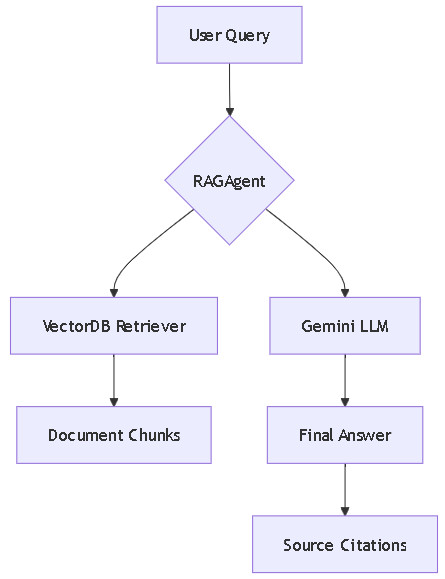

In [28]:
# UI MODULE

class RAGUI:
    """User interface for the RAG application."""

    def __init__(self):
        """Initialize the UI components."""
        self.rag_agent = None
        self.document_processor = None
        self.vector_db_manager = None
        self.vector_db = None

        # UI components
        self.doc_path_input = widgets.Text(
            value=Config.DOC_DIR,
            description='Document Path:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='40%')
        )

        self.load_docs_button = widgets.Button(
            description='Load Documents',
            button_style='primary',
            layout=widgets.Layout(width='10%')
        )
        self.load_docs_button.on_click(self.load_documents_callback)

        self.status_output = widgets.Output(layout={'border': '1px solid #ddd'})

        self.question_input = widgets.Text(
            value='',
            placeholder='Ask a question about your documents...',
            description='Question:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='40%'),
            disabled=True
        )
        self.question_input.on_submit(self.answer_question_callback)

        self.ask_button = widgets.Button(
            description='Ask',
            button_style='success',
            layout=widgets.Layout(width='5%'),
            disabled=True
        )
        self.ask_button.on_click(self.answer_question_callback)

        self.reset_chat_button = widgets.Button(
            description='Reset Chat',
            button_style='warning',
            layout=widgets.Layout(width='5%'),
            disabled=True
        )
        self.reset_chat_button.on_click(self.reset_chat_callback)

        self.answer_output = widgets.Output(layout={'border': '1px solid #ddd'})

    def display_ui(self) -> None:
        """Display the complete UI."""
        # First check and request API keys
        setup_api_keys()
        if not Config.HF_TOKEN or not Config.GENAI_API_KEY:
            request_api_keys()

        # App title
        display(HTML("<h1>RAG-Powered Document Q&A System</h1>"))

        # Document loading section
        display(HTML("<h2>1. Document Processing</h2>"))
        display(widgets.HBox([self.doc_path_input, self.load_docs_button]))
        display(self.status_output)

        # Q&A section
        display(HTML("<h2>2. Ask Questions</h2>"))
        display(widgets.HBox([self.question_input, self.ask_button, self.reset_chat_button]))
        display(self.answer_output)

        # Display initial status
        with self.status_output:
            print("Status: Ready to load documents")
            print(f"Document directory: {Config.DOC_DIR}")
            print(f"Vector DB directory: {Config.DB_DIR}")
            if os.path.exists(os.path.join(Config.DB_DIR, 'index')):
                print("An existing vector database was found and will be used if no new documents are loaded.")

    def load_documents_callback(self, button) -> None:
        """Callback for document loading button."""
        with self.status_output:
            clear_output()
            print(f"Loading documents from: {self.doc_path_input.value}")

            try:
                # Update document directory in config
                Config.DOC_DIR = self.doc_path_input.value

                # Initialize document processor
                self.document_processor = DocumentProcessor()

                # Load documents
                documents, failed_files = self.document_processor.load_documents(Config.DOC_DIR)

                if not documents:
                    print("⚠️ No documents were loaded successfully. Please check the document directory.")
                    if failed_files:
                        print(f"Failed files: {', '.join([os.path.basename(f) for f in failed_files])}")
                    return

                # Chunk documents
                document_chunks = self.document_processor.chunk_documents(
                    documents,
                    config=Config  # Pass the entire config
                    #chunk_size=Config.CHUNK_SIZE,
                    #chunk_overlap=Config.CHUNK_OVERLAP
                )

                # Initialize vector database
                self.vector_db_manager = VectorDBManager(
                    embedding_model_name=Config.EMBEDDING_MODEL,
                    persist_dir=Config.DB_DIR
                )

                # Create or load vector database
                self.vector_db = self.vector_db_manager.create_or_load_db(document_chunks)

                # Fix persistence warning
                if hasattr(self.vector_db, 'persist'):
                    print("Note: Using Chroma DB which now auto-persists data")

                # Initialize RAG agent
                self.rag_agent = RAGAgent(self.vector_db, api_key=Config.GENAI_API_KEY)

                # Enable Q&A components
                self.question_input.disabled = False
                self.ask_button.disabled = False
                self.reset_chat_button.disabled = False

                print("✅ System ready for questions!")

            except Exception as e:
                print(f"❌ Error during document processing: {str(e)}")

    def answer_question_callback(self, widget) -> None:
        """Callback for question answering."""
        question = self.question_input.value

        if not question.strip():
            return

        with self.answer_output:
            clear_output()
            print(f"Q: {question}")
            print("Thinking...")

            if self.rag_agent:
                try:
                    result = self.rag_agent.answer_question(question)

                    clear_output()
                    print(f"Q: {question}")
                    print(f"\nA: {result['answer']}")

                    if result.get('sources'):
                        print(f"\nSources: {', '.join(result['sources'])}")

                    if result.get('error'):
                        print(f"\nError details: {result['error']}")
                except Exception as e:
                    clear_output()
                    print(f"Q: {question}")
                    print(f"\nA: I encountered an error while trying to answer your question.")
                    print(f"\nError details: {str(e)}")
            else:
                print("❌ System not initialized. Please load documents first.")

        # Clear the question input
        self.question_input.value = ''

    def reset_chat_callback(self, button) -> None:
        """Callback to reset the chat history."""
        if self.rag_agent:
            self.rag_agent.reset_memory()

            with self.answer_output:
                clear_output()
                print("Chat history has been reset.")

In [29]:
# MAIN APP

def main():
    """Main entry point for the application."""
    print("Starting RAG-Powered Document Q&A System...")

    # Debug - print environment variables (without showing key values)
    print("\nChecking for environment variables:")
    for env_var in ['HUGGINGFACEHUB_API_TOKEN', 'GEMINI_API_KEY']:
        if env_var in os.environ:
            print(f" Local Env ✓ {env_var} is set")
        else:
            print(f" Local Env ✗ {env_var} is not set")

    # Create and display UI
    ui = RAGUI()
    ui.display_ui()

# Run the application
main()

# EXAMPLE USAGE

from IPython.display import display, HTML

display(HTML('''
<style>
    .modern-container {
        max-width: 800px;
        margin: 0 auto;
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        line-height: 1.6;
    }

    .section-header {
        color: #2c3e50;
        border-bottom: 2px solid #3498db;
        padding: 15px 0;
        margin: 25px 0 15px;
    }

    .card {
        background: #ffffff;
        border-radius: 8px;
        box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        padding: 20px;
        margin: 15px 0;
    }

    .card h3 {
        color: #34495e;
        margin-top: 0;
    }

    .code-snippet {
        background: #f8f9fa;
        border: 1px solid #e1e4e8;
        border-radius: 4px;
        padding: 8px 12px;
        font-family: 'Courier New', Courier, monospace;
        color: #d63384;
    }

    .list-item {
        margin: 10px 0;
        padding-left: 20px;
        position: relative;
    }

    .list-item::before {
        content: '';
        position: absolute;
        left: 0;
        top: 50%;
        transform: translateY(-50%);
        width: 8px;
        height: 8px;
        background: #1abc9c;
        border-radius: 50%;
    }
</style>

<div class="modern-container">
    <div class="card">
        <h2 class="section-header">Example Test Queries</h2>
        <div class="list-item">
            <h3>Basic information retrieval:</h3>
            <p class="code-snippet">"What are the main topics covered in these documents?"</p>
        </div>
        <div class="list-item">
            <h3>Specific information retrieval:</h3>
            <p class="code-snippet">"What does [specific document] say about [specific topic]?"</p>
        </div>
        <div class="list-item">
            <h3>Comparative analysis:</h3>
            <p class="code-snippet">"Compare how different documents approach [topic]."</p>
        </div>
        <div class="list-item">
            <h3>Follow-up questions:</h3>
            <p class="code-snippet">"Tell me more about [something mentioned in previous answer]."</p>
        </div>
    </div>

    <div class="card">
        <h2 class="section-header">Customization Options</h2>
        <div class="list-item">
            <h3>Change embedding model:</h3>
            <p>Modify <span class="code-snippet">Config.EMBEDDING_MODEL</span> to use different HuggingFace models</p>
            <p class="code-snippet">"sentence-transformers/all-mpnet-base-v2"</p>
        </div>
        <div class="list-item">
            <h3>Adjust chunking parameters:</h3>
            <p>Modify <span class="code-snippet">Config.CHUNK_SIZE</span> and <span class="code-snippet">Config.CHUNK_OVERLAP</span></p>
        </div>
        <div class="list-item">
            <h3>Tune retrieval parameters:</h3>
            <p>Adjust <span class="code-snippet">Config.TOP_K_RETRIEVAL</span></p>
        </div>
        <div class="list-item">
            <h3>Switch vector database:</h3>
            <p>Use <span class="code-snippet">"faiss"</span> instead of <span class="code-snippet">"chroma"</span></p>
        </div>
        <div class="list-item">
            <h3>Modify LLM parameters:</h3>
            <p>Adjust <span class="code-snippet">temperature</span> and <span class="code-snippet">top_p</span> in <span class="code-snippet">RAGAgent.__init__()</span></p>
        </div>
    </div>
</div>
'''))

Starting RAG-Powered Document Q&A System...

Checking for environment variables:
 Local Env ✗ HUGGINGFACEHUB_API_TOKEN is not set
 Local Env ✗ GEMINI_API_KEY is not set
✅ Hugging Face token synced with Colab secrets
✅ Gemini API key synced with Colab secrets


Output(layout=Layout(border='1px solid #ddd'))

Output(layout=Layout(border='1px solid #ddd'))